In [12]:
import numpy as np
import numpy.random as rnd
import scipy.stats as stats
import math as math
import random as random
import matplotlib.pyplot as plt

# Simulated Annealing

### 1)

Random Walk Metropolis-Hastings algorithm to simulate a solution to the TSP.
The function takes a random starting guess of a route $x_0$ and a cost matrix $\mathbf{M}_{i,j}$ where each index is the cost of moving from city $i$ to $j$.
In each iteration the current route is permutated by switching two random cities in the route. The first city $i$ is chosen from a discrete uniform distribtution from all cities, the second city $j$ is found using sample rejection from a discrete unifomr distribtution s.t. $j \neq i$.

In the test problem using points distributed evenly on the perimiter of the unit circle, and a cost equal to the distance between two points, the algortithm seems to converge to the correct solution every time.
When moving on to the actual TSP with 20 cities, the algortihm does not converge to the same solution each time.

In [184]:
n = 10 # Number of cities
x0 = random.sample(range(0,n), n) # Start with a random permutation


def place_cities_on_unit_circle(n):
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    x_coords = np.zeros(n)
    y_coords = np.zeros(n)
    for i in range(n):
        x_coords[i] = np.sin(angles[i])
        y_coords[i] = np.cos(angles[i])
    x_coords = np.roll(x_coords, -1)
    y_coords = np.roll(y_coords, -1)
    return x_coords, y_coords

def getCityDistances(x_coords, y_coords):
    M = np.zeros((len(x_coords), len(y_coords)))
    for i in range(len(x_coords)):
        for j in range(len(y_coords)):
            if j==i:
                continue
            else:
                dist = np.sqrt((x_coords[i]- x_coords[j])**2 + (y_coords[i] - y_coords[j])**2)
                M[i,j] = dist
    return M

def getCost(x, M):
    cost = M[x[-1], x[0]]
    for i in range(0,len(x)-1):
        xi = x[i]
        xip1 = x[i+1]
        cost += M[xi, xip1]
    return cost
def Tk(k):
    return 1 / np.sqrt(1 + k)
    #return -np.log(k + 1)

def RWMH(x0, M, iter = 1000):
    switched = 0
    routes = []
    routes.append(x0)
    costs = []
    costs.append(getCost(x0, M))
    n = len(x0)
    for l in range(iter):
        current_route = routes[l]
        current_cost = costs[l]
        # Get two random indexes
        i = int(rnd.randint(low = 0, high = n, size = 1))
        j = i
        while i == j:
            j = int(rnd.randint(low = 0, high = n, size = 1))
        new_route = current_route.copy()
        # Switch indices
        new_route[i] = current_route[j]
        new_route[j] = current_route[i]
        new_cost = getCost(new_route, M)

        tk = Tk(iter)
        U = rnd.uniform(size = 1)
        if U <= min(current_cost / new_cost, np.exp(-(new_cost - current_cost) / tk) ):
            costs.append(new_cost)
            routes.append(new_route)
            switched += 1
        else:
            costs.append(current_cost)
            routes.append(current_route)
    return costs, routes, switched

x_coords, y_coords = place_cities_on_unit_circle(n)
M = getCityDistances(x_coords, y_coords)

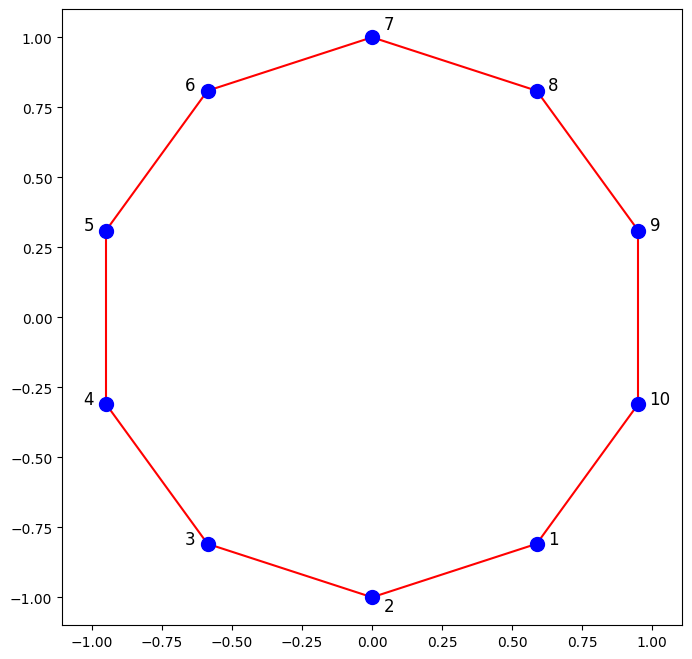

In [187]:
costs, routes, switch = RWMH(x0, M, iter = 10000)

def plotRoute(x0, x_coords, y_coords):
    plt.figure(figsize=(8, 8))
    count = 1
    # Plot the cities as points and annotate them
    for i in x0:
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, color='red')  # Plot the city
        if x < 0:
            xtext = x - 0.08
        else:
            xtext = x + 0.04      
        if y < 0 and x < 0.1 and x > -0.1:
            ytext  = y - 0.05
        elif y > 0 and x < 0.1 and x > -0.1:
            ytext = y + 0.03
        else:
            ytext = y
        plt.text(xtext, ytext, str(count), color='black', fontsize=12)  # Annotate the city with its order
        count += 1
    
    # Plot lines between each city in order
    for i in range(len(x_coords)):
        next_i = (i + 1) % len(x_coords)  # Ensure the last city connects to the first
        plt.plot([x_coords[i], x_coords[next_i]], [y_coords[i], y_coords[next_i]], 'r-')
    
    # Highlight the starting city
    plt.scatter([x_coords[x0]], [y_coords[x0]], color='blue', zorder=5, s=100)  # Highlight the starting point with a larger, blue dot
    plt.axis('equal')  # Equal aspect ratio ensures that 1 unit in x is equal to 1 unit in y
    plt.show()
x = routes[-1]
plotRoute(x, x_coords, y_coords)

### 2 Modify code to work with cost matrix directly
The code already works with an arbritrary cost matrix, it can just be run as is. The number of cities is set to the number of rows in the matrix.

In [ ]:
costMatrix = np.loadtxt('cost.csv', delimiter=',')
n = np.shape(costMatrix)[0]
x0 = random.sample(range(0,n), n)
x_coords, y_coords = place_cities_on_unit_circle(n)
costs, routes, switch = RWMH(x0, costMatrix, iter = 10000)


def plotRoute2(x0, x_coords, y_coords, M, totalCost):
    plt.figure(figsize=(10, 10))
    count = 1
    colors = ['blue', 'green', 'red',  'magenta',  'black']  # Color cycle
    color_index = 0  # To keep track of the current color
    
    for i in range(len(x0)):
        current_index = x0[i]
        next_index = x0[(i + 1) % len(x0)]  # Ensure the route loops back to the start
        
        x_current = x_coords[i]
        y_current = y_coords[i]
        x_next = x_coords[(i + 1) % len(x0)]
        y_next = y_coords[(i + 1) % len(x0)]
        
        current_color = colors[color_index % len(colors)]  # Get current color from cycle
        
        plt.scatter(x_current, y_current, color=current_color)  # Plot the city
        xtext, ytext = adjustTextPosition(x_current, y_current)
        plt.text(xtext, ytext, str(x0[i]), color='black', fontsize=12)  # Annotate the city with its order
        
        cost = M[current_index, next_index]
        midpoint_x = (x_current + x_next) / 2
        midpoint_y = (y_current + y_next) / 2
        midpoint_x, midpoint_y = adjustTextPosition(midpoint_x, midpoint_y)
        plt.text(midpoint_x, midpoint_y, f'{int(cost)}', color=current_color, fontsize=10)  # Display the cost
        
        plt.plot([x_current, x_next], [y_current, y_next], color=current_color)  # Draw the line
        
        color_index += 1  # Move to the next color for the next line
    
    x_start, y_start = x_coords[x0[0]], y_coords[x0[0]]
    plt.scatter([x_start], [y_start], color='blue', zorder=5, s=100)  # Highlight the starting point
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Optimal Route for the problem\n Optimal route cost = {totalCost} \n Point numbers are city numbers, colored numbers are route costs' )
    plt.show()

def adjustTextPosition(x, y):
    # Adjust text position based on city location
    if x < 0:
        xtext = x - 0.07
    else:
        xtext = x + 0.02
    if y < 0: #and x < 0.1 and x > -0.1:
        ytext = y - 0.05
    elif y > 0: #and x < 0.1 and x > -0.1:
        ytext = y + 0.01
    else:
        ytext = y
    return xtext, ytext



Visualisation of the found optimal route. Each city is marked with a point and it's number between 1 and  20. The cost of travelling to the next city for all routes is marked along the path.

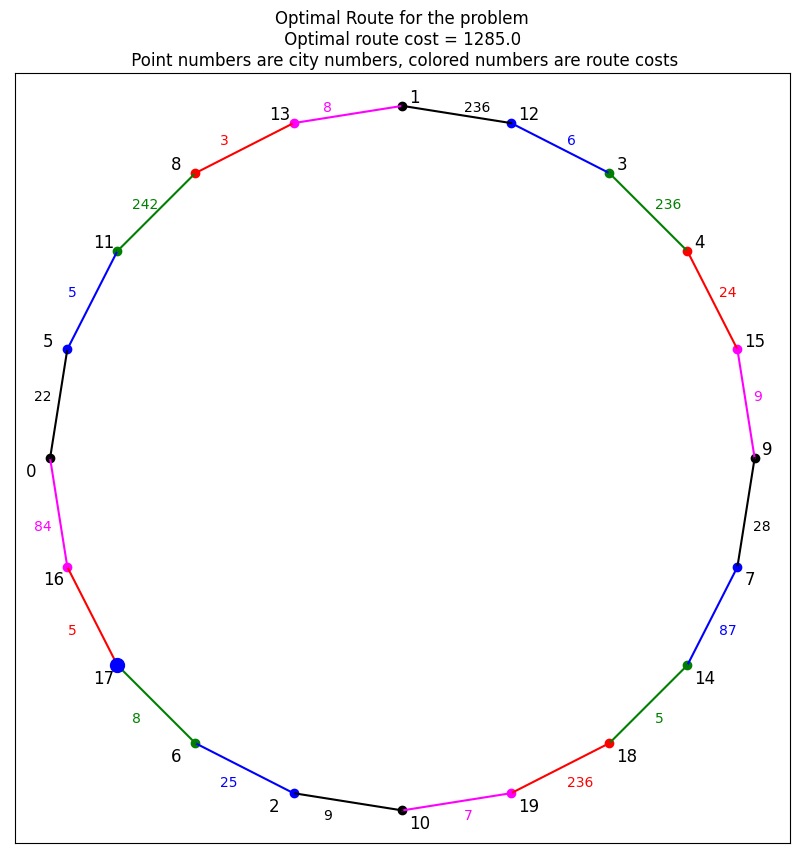

In [323]:
plotRoute2(routes[-1], x_coords, y_coords, costMatrix, costs[-1])

# Exercise 8


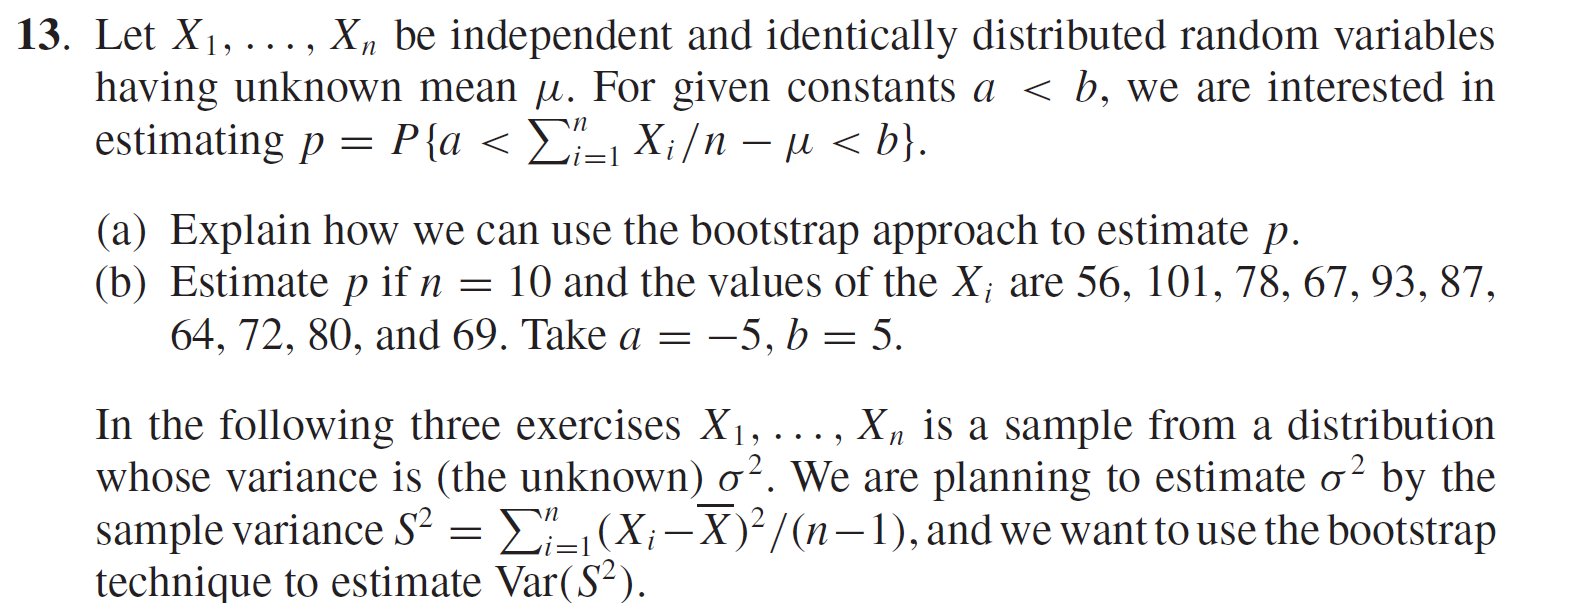

### a)
Sample $n$ numbers from the emperical distribution $ X_1,... X_n $ with replacement, do this a large amount of times, and find the mean of these samples $\bar{\mu}$. For all samples, find the probabilty $p$ that a given sample satisfies the relation.

This can even be done a large amount of times, to get a confidence interval for $p$

### b)
When $n=10$ sample $10 \times 10000$ from the empirical distribution, and find $p$. Here we do this $500$ times to also get a $95\%$ CI for $p$.

In [232]:
Xs = np.array([56, 101, 78, 67, 93, 87, 64, 72, 80, 69])
mu = np.mean(Xs)

ps = []
m = 10000
k = 500

a = -5
b = 5

for i in range(k):
    sample = rnd.choice(Xs, (len(Xs),m), replace = True)
    mu = np.mean(np.mean(sample, axis= 0))
    sample = sample - mu
    me = np.mean(sample, axis = 0)

    p = np.mean((me > a) * (me < b))
    ps.append(p)

In [233]:
alpha = 0.05
low = np.quantile(ps, alpha/2)
high = np.quantile(ps, 1 - alpha/2)
print(f"Mean probabilty = {round(np.mean(ps),3)*100}%")
print(f"95% CI: [{round(low,3)},{round(high,3)}]")

Mean probabilty = 76.7%
95% CI: [0.758,0.774]


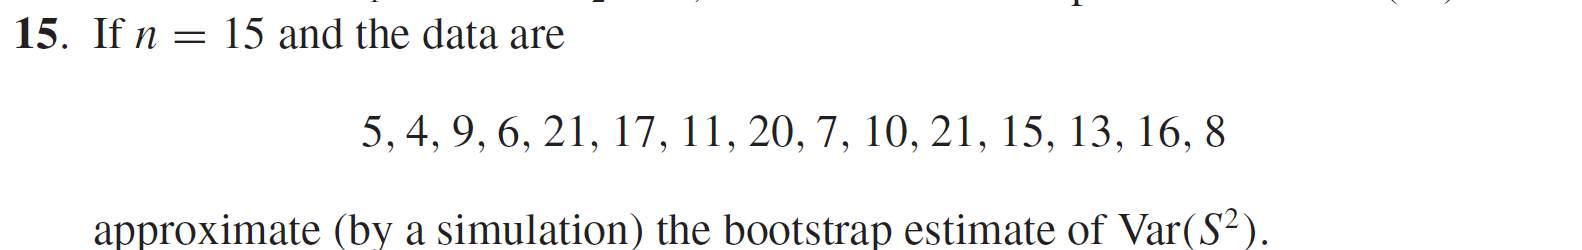

## UNCHANGED

To find the variance of the sample variance we sample $15$ ranom numbers from the dataset $m = 10000$ times. For each sample of $15$ find it's variance. Then find the variance of the $m$ estimated variances.

Notice the variance in a given sample is not very large, but the variance between samples varies a lot. This may be attributed to the emipircal distribution having large amounts of either relatively small numbers, and relatively large numbers. This means the variances between samples can change drastically.

Variance in the sample variance is: 60.145


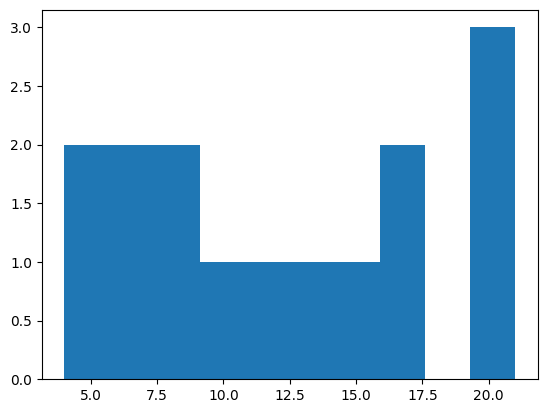

In [275]:
Xs = np.array([5, 4, 9, 6, 21, 17, 11, 20, 7, 10, 21, 15, 13, 16, 8])
m = 10000
vars = []
sample = rnd.choice(Xs, (len(Xs),m), replace = True)
var = np.var(sample, ddof= 1, axis = 0)

print("Variance in the sample variance is:", round(np.var(var, ddof=1),3))
_ = plt.hist(Xs, bins = 10)

## 3) CHANGED
Recall for the Pareto distribution that the mean of the sample is not well explained by the majority of points in the distribtution. This means it's difficult to sample enough points to accurately estimate the mean, resulting in a large variance in our estimate of it.
This is not the case for the median value, which can be seen in it's low bootstrap variance. The median is more robust to what could be thought of as outliers. They are of course not really outliers, but in this case the few sampled large values, which so heavily sway the mean value, do not affect the median, since there's not a lot of them.

In [279]:
def generatePareto(k, beta = 1, n = 10000):
    Us = rnd.rand(n)
    return beta * (Us**(-1/k)) 
beta = 1
k = 1.05
N = 200
r = 100
Xs = generatePareto(k, beta, N)
dist_mean = np.mean(Xs)
dist_median = np.median(Xs)

print(f"The mean of the generated variables is {round(dist_mean,3)}")
print(f"The median of the generated variables is {round(dist_median,3)}")

The mean of the generated variables is 5.89
The median of the generated variables is 1.644


In [280]:

samples = rnd.choice(Xs, (len(Xs), r) , replace = True)
means = np.mean(samples, axis=0)
medians = np.median(samples, axis=0)

print(f"Bootstrap of the variance of sample mean: {round(np.var(means, ddof = 1),3)}")
print(f"Bootstrap of the variance of sample median: {round(np.var(medians, ddof = 1),3)}")

Bootstrap of the variance of sample mean: 2.08
Bootstrap of the variance of sample median: 0.017
